<a href="https://colab.research.google.com/github/gremlin97/EVA-8/blob/main/S8/S8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install grad-cam
!pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
!git clone https://github.com/gremlin97/EVA-Utils

Cloning into 'EVA-Utils'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 83 (delta 45), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (83/83), 20.61 KiB | 844.00 KiB/s, done.


In [21]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [22]:
%cd EVA-Utils

/content/EVA-Utils/EVA-Utils


In [23]:
from main import *
from utils import *

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = A.Compose([
    A.RandomCrop(32,32),
    A.HorizontalFlip(p=0.5),
    A.Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=127),
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    ToTensorV2()
])

class Cifar10(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainset = Cifar10(root='./data', train=True,download=True, transform=train_transform)
testset = Cifar10(root='./data', train=False,download=True, transform=test_transform)

def init_dataloader(batch):
  trainloader = torch.utils.data.DataLoader(trainset,batch_size = 512, shuffle=True)
  testloader = torch.utils.data.DataLoader(testset,batch_size = 512, shuffle=True)
  return trainloader, testloader

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [25]:
class ResnetF(nn.Module):
  def __init__(self):
    super().__init__()
    self.prep = nn.Sequential(
        nn.Conv2d(3, 64 , 3 , 1 ,1),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    )
    self.layer1 = nn.Sequential(
        nn.Conv2d(64, 128, 3, 1, 1),
        nn.MaxPool2d(2,2),
        nn.ReLU(),
        nn.BatchNorm2d(128)
    )
    self.residual1 = nn.Sequential(
        nn.Conv2d(128, 128, 3, 1, 1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, 3, 1, 1),
        nn.ReLU(),
        nn.BatchNorm2d(128)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(128, 256, 3, 1, 1),
        nn.MaxPool2d(2,2),
        nn.ReLU(),
        nn.BatchNorm2d(256)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(256, 512, 3, 1, 1),
        nn.MaxPool2d(2,2),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.Dropout(0.1)
    )
    self.residual2 = nn.Sequential(
      nn.Conv2d(512, 512, 3, 1, 1),
      nn.ReLU(),
      nn.BatchNorm2d(512),
      nn.Conv2d(512, 512, 3, 1, 1),
      nn.ReLU(),
      nn.BatchNorm2d(512)
    )
    self.maxpool = nn.MaxPool2d(4,2)
    self.fc = nn.Linear(512,10)
    self.softmax = nn.Softmax()
    
  
  def forward(self, x):
    x = self.prep(x)
    residual1 = self.layer1(x)
    x = self.residual1(residual1)
    x += residual1
    x = self.layer2(x)
    residual2 = self.layer3(x)
    x = self.residual2(residual2)
    x += residual2
    x = self.maxpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    x = self.softmax(x)
    return x

In [26]:
model = ResnetF()

In [27]:
from torchsummary import summary
summary(model.to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
              ReLU-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         147,584
             ReLU-12          [-1, 128, 16, 16]               0
      BatchNorm2d-13          [-1, 128, 16, 16]             256
           Conv2d-14          [-1, 256,

<ipython-input-25-52ab6c361b94>:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


In [28]:
def init_optim(lr=0.01):
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  criterion = nn.CrossEntropyLoss()
  return optimizer, criterion

  0%|          | 0/200 [00:00<?, ?it/s]

<ipython-input-25-52ab6c361b94>:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.01E-02


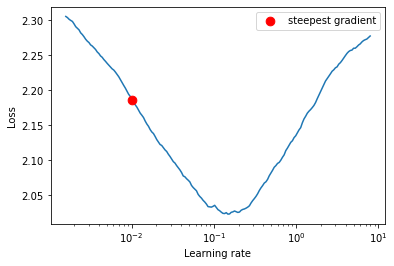

In [29]:

from torch_lr_finder import LRFinder

trainloader, testloader = init_dataloader(512)
optimizer, criterion = init_optim(0.001)
model = model
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=10, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [30]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.14820207057988585


In [31]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(trainloader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10,
                                                three_phase=False, 
                                                final_div_factor=100,
                                                anneal_strategy='linear'
                                                ) 

In [32]:
def train_gen(model, epochs, optimizer, trainloader):
  loss_arr = []
  model.train()
  for epoch in range(epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      correct = 0
      for i, data in enumerate(trainloader, 0):
          
          # get the inputs
          inputs, labels = data

          inputs=inputs.to(device)
          labels=labels.to(device)
                          
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          scheduler.step()

          # print statistics
          running_loss += loss.item()
          pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(labels.view_as(pred)).sum().item()
          acc = 100. * correct / len(trainloader.dataset)
          
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
              running_loss = 0.0
      print("Accuracy is:",acc)
      loss_arr.append(running_loss/len(trainloader.dataset))
      my_lr = scheduler.get_last_lr()
      print("LR is :",my_lr)
      print("Epoch is:",epoch)

  print('Finished Training')
  return loss_arr

In [33]:
loss_arr = train_gen(model, 24, optimizer, trainloader)

<ipython-input-25-52ab6c361b94>:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Accuracy is: 37.122
LR is : [0.04266729403103062]
Epoch is: 0
Accuracy is: 53.902
LR is : [0.07051438100407266]
Epoch is: 1
Accuracy is: 62.012
LR is : [0.09836146797711469]
Epoch is: 2
Accuracy is: 67.01
LR is : [0.12620855495015673]
Epoch is: 3
Accuracy is: 69.902
LR is : [0.14658278022665575]
Epoch is: 4
Accuracy is: 72.616
LR is : [0.13887936009963878]
Epoch is: 5
Accuracy is: 74.99
LR is : [0.13117593997262178]
Epoch is: 6
Accuracy is: 77.318
LR is : [0.12347251984560481]
Epoch is: 7
Accuracy is: 78.404
LR is : [0.11576909971858781]
Epoch is: 8
Accuracy is: 79.556
LR is : [0.10806567959157085]
Epoch is: 9
Accuracy is: 80.874
LR is : [0.10036225946455386]
Epoch is: 10
Accuracy is: 81.862
LR is : [0.09265883933753688]
Epoch is: 11
Accuracy is: 83.066
LR is : [0.0849554192105199]
Epoch is: 12
Accuracy is: 84.192
LR is : [0.07725199908350291]
Epoch is: 13
Accuracy is: 84.824
LR is : [0.06954857895648592]
Epoch is: 14
Accuracy is: 86.146
LR is : [0.061845158829468935]
Epoch is: 15
Accu

In [37]:
import torchvision.transforms.functional as TF

def test_gen(model, testloader):
  inc = []
  pre = []
  correct = 0
  total = 0
  test_loss = 0
  model.eval()
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images=images.to(device)
          labels=labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # Store wrongly predicted images
          if (predicted != labels).sum().item()>0:
            wrong_idx = ((predicted != labels).nonzero()[:,0])[0].item()
            wrong_samples = images[wrong_idx]
            wrong_preds = predicted[wrong_idx]
            actual_preds = labels.view_as(predicted)[wrong_idx]

            # Undo normalization
            wrong_samples = wrong_samples * 0.5
            wrong_samples = wrong_samples + 0.5
            wrong_samples = wrong_samples * 255.
            wrong_samples = wrong_samples.byte()
            img = TF.to_pil_image(wrong_samples)
            # print(img.shape)
            inc.append(img)
            pre.append(wrong_preds)

      plot_arr = []
      for i in range(len(inc)):
        # plot_arr.append(inc[i].cpu().data.numpy()[0])
        plot_arr.append(inc[i])

  print('Accuracy of the model on the 10000 test images: %d %%' % (
      100 * correct / total))
  
  return plot_arr, pre

In [39]:
plot_arr, pre = test_gen(model, testloader)

<ipython-input-25-52ab6c361b94>:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Accuracy of the model on the 10000 test images: 87 %


In [40]:
Train_Logs=([
  '''
    Accuracy is: 37.122
    LR is : [0.04266729403103062]
    Epoch is: 0
    Accuracy is: 53.902
    LR is : [0.07051438100407266]
    Epoch is: 1
    Accuracy is: 62.012
    LR is : [0.09836146797711469]
    Epoch is: 2
    Accuracy is: 67.01
    LR is : [0.12620855495015673]
    Epoch is: 3
    Accuracy is: 69.902
    LR is : [0.14658278022665575]
    Epoch is: 4
    Accuracy is: 72.616
    LR is : [0.13887936009963878]
    Epoch is: 5
    Accuracy is: 74.99
    LR is : [0.13117593997262178]
    Epoch is: 6
    Accuracy is: 77.318
    LR is : [0.12347251984560481]
    Epoch is: 7
    Accuracy is: 78.404
    LR is : [0.11576909971858781]
    Epoch is: 8
    Accuracy is: 79.556
    LR is : [0.10806567959157085]
    Epoch is: 9
    Accuracy is: 80.874
    LR is : [0.10036225946455386]
    Epoch is: 10
    Accuracy is: 81.862
    LR is : [0.09265883933753688]
    Epoch is: 11
    Accuracy is: 83.066
    LR is : [0.0849554192105199]
    Epoch is: 12
    Accuracy is: 84.192
    LR is : [0.07725199908350291]
    Epoch is: 13
    Accuracy is: 84.824
    LR is : [0.06954857895648592]
    Epoch is: 14
    Accuracy is: 86.146
    LR is : [0.061845158829468935]
    Epoch is: 15
    Accuracy is: 86.926
    LR is : [0.054141738702451966]
    Epoch is: 16
    Accuracy is: 87.696
    LR is : [0.04643831857543497]
    Epoch is: 17
    Accuracy is: 88.402
    LR is : [0.03873489844841799]
    Epoch is: 18
    Accuracy is: 89.13
    LR is : [0.031031478321401018]
    Epoch is: 19
    Accuracy is: 89.952
    LR is : [0.02332805819438402]
    Epoch is: 20
    Accuracy is: 90.718
    LR is : [0.015624638067367025]
    Epoch is: 21
    Accuracy is: 91.468
    LR is : [0.007921217940350056]
    Epoch is: 22
    Accuracy is: 92.146
    LR is : [0.00021779781333305936]
    Epoch is: 23
    Finished Training
    Accuracy of the model on the 10000 test images: 87 %

  ''',
  '''
    Accuracy is: 38.238
    LR is : [0.03756805566869756]
    Accuracy is: 49.176
    LR is : [0.06208709155725109]
    Accuracy is: 55.104
    LR is : [0.08660612744580463]
    Accuracy is: 65.9
    LR is : [0.11112516333435817]
    Accuracy is: 70.176
    LR is : [0.1290644314969333]
    Accuracy is: 73.582
    LR is : [0.12228165975704595]
    Accuracy is: 76.028
    LR is : [0.11549888801715859]
    Accuracy is: 77.916
    LR is : [0.10871611627727124]
    Accuracy is: 79.504
    LR is : [0.10193334453738387]
    Accuracy is: 80.976
    LR is : [0.0951505727974965]
    Accuracy is: 82.206
    LR is : [0.08836780105760914]
    Accuracy is: 83.702
    LR is : [0.08158502931772177]
    Accuracy is: 84.734
    LR is : [0.07480225757783442]
    Accuracy is: 85.594
    LR is : [0.06801948583794705]
    Accuracy is: 86.586
    LR is : [0.06123671409805968]
    Accuracy is: 87.592
    LR is : [0.054453942358172316]
    Accuracy is: 88.898
    LR is : [0.047671170618284964]
    Accuracy is: 89.546
    LR is : [0.0408883988783976]
    Accuracy is: 90.088
    LR is : [0.03410562713851023]
    Accuracy is: 90.908
    LR is : [0.027322855398622878]
    Accuracy is: 91.818
    LR is : [0.02054008365873551]
    Accuracy is: 92.696
    LR is : [0.01375731191884813]
    Accuracy is: 93.274
    LR is : [0.006974540178960778]
    Accuracy is: 93.726
    LR is : [0.00019176843907339758]
    Finished Training
    Accuracy of the model on the 10000 test images: 87 %
  ''',
  '''
      Accuracy is: 41.414
    LR is : [0.01122780921210248]
    /usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:1679: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
      warnings.warn("To get the last learning rate computed by the scheduler, "
    Accuracy is: 54.316
    LR is : [0.01123120359240308]
    Accuracy is: 60.864
    LR is : [0.011236860723964834]
    Accuracy is: 65.904
    LR is : [0.011244780353386746]
    Accuracy is: 72.582
    LR is : [0.011254962125923446]
    Accuracy is: 78.536
    LR is : [0.01126740558550085]
    Accuracy is: 81.3
    LR is : [0.011282110174736792]
    Accuracy is: 83.556
    LR is : [0.011299075234965858]
    Accuracy is: 85.128
    LR is : [0.011318300006268961]
    Accuracy is: 87.088
    LR is : [0.011339783627507316]
    Accuracy is: 87.92
    LR is : [0.011363525136361116]
    Accuracy is: 88.826
    LR is : [0.011389523469372512]
    Accuracy is: 89.946
    LR is : [0.011417777461993336]
    Accuracy is: 90.914
    LR is : [0.011448285848637274]
    Accuracy is: 91.738
    LR is : [0.011481047262736452]
    Accuracy is: 92.638
    LR is : [0.011516060236802766]
    Accuracy is: 92.78
    LR is : [0.011553323202493568]
    Accuracy is: 93.622
    LR is : [0.011592834490681894]
    Accuracy is: 93.912
    LR is : [0.011634592331531246]
    Accuracy is: 94.3
    LR is : [0.011678594854574939]
    Accuracy is: 94.576
    LR is : [0.011724840088799704]
    Accuracy is: 94.926
    LR is : [0.011773325962734213]
    Accuracy is: 95.208
    LR is : [0.011824050304541686]
    Accuracy is: 95.616
    LR is : [0.01187701084211723]
    Finished Training

    Accuracy of the model on the 10000 test images: 86 %
  '''
  ,
  '''
    Accuracy is: 41.076
    Accuracy is: 60.404
    Accuracy is: 68.36
    Accuracy is: 73.442
    Accuracy is: 77.104
    Accuracy is: 80.478
    Accuracy is: 82.288
    Accuracy is: 83.778
    Accuracy is: 85.682
    Accuracy is: 87.01
    Accuracy is: 88.096
    Accuracy is: 89.156
    Accuracy is: 90.374
    Accuracy is: 91.14
    Accuracy is: 91.876
    Accuracy is: 92.656
    Accuracy is: 92.902
    Accuracy is: 93.68
    Accuracy is: 94.132
    Accuracy is: 94.566
    Accuracy is: 94.894
    Accuracy is: 95.282
    Accuracy is: 95.51
    Accuracy is: 95.846
    Finished Training
    Accuracy of the model on the 10000 test images: 85 %
  '''
    ,
  '''
   Accuracy is: 39.128
  Accuracy is: 61.672
  Accuracy is: 68.924
  Accuracy is: 73.4
  Accuracy is: 75.856
  Accuracy is: 77.788
  Accuracy is: 79.054
  Accuracy is: 80.786
  Accuracy is: 82.162
  Accuracy is: 83.354
  Accuracy is: 84.122
  Accuracy is: 85.192
  Accuracy is: 85.856
  Accuracy is: 86.614
  Accuracy is: 87.208
  Accuracy is: 87.816
  Accuracy is: 88.506
  Accuracy is: 88.852
  Accuracy is: 89.284
  Accuracy is: 90.088
  Accuracy is: 90.162
  Accuracy is: 90.856
  Accuracy is: 91.142
  Accuracy is: 91.642
  Finished Training
  Accuracy of the model on the 10000 test images: 85 %

  ''',
    '''
       <ipython-input-7-f0e4748f9bea>:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)
[1,  2000] loss: 6.114
[1,  4000] loss: 5.987
[1,  6000] loss: 5.926
[1,  8000] loss: 5.897
[1, 10000] loss: 5.881
[1, 12000] loss: 5.858
Accuracy is: 33.234
[2,  2000] loss: 5.812
[2,  4000] loss: 5.795
[2,  6000] loss: 5.784
[2,  8000] loss: 5.786
[2, 10000] loss: 5.753
[2, 12000] loss: 5.741
Accuracy is: 48.328
[3,  2000] loss: 5.721
[3,  4000] loss: 5.716
[3,  6000] loss: 5.702
[3,  8000] loss: 5.686
[3, 10000] loss: 5.697
[3, 12000] loss: 5.687
Accuracy is: 55.704
[4,  2000] loss: 5.659
[4,  4000] loss: 5.666
[4,  6000] loss: 5.656
[4,  8000] loss: 5.662
[4, 10000] loss: 5.646
[4, 12000] loss: 5.645
Accuracy is: 60.004
[5,  2000] loss: 5.625
[5,  4000] loss: 5.630
[5,  6000] loss: 5.628
[5,  8000] loss: 5.612
[5, 10000] loss: 5.614
[5, 12000] loss: 5.609
Accuracy is: 63.39
[6,  2000] loss: 5.596
[6,  4000] loss: 5.588
[6,  6000] loss: 5.593
[6,  8000] loss: 5.590
[6, 10000] loss: 5.576
[6, 12000] loss: 5.573
Accuracy is: 67.002
[7,  2000] loss: 5.562
[7,  4000] loss: 5.564
[7,  6000] loss: 5.559
[7,  8000] loss: 5.559
[7, 10000] loss: 5.563
[7, 12000] loss: 5.555
Accuracy is: 69.378
[8,  2000] loss: 5.539
[8,  4000] loss: 5.536
[8,  6000] loss: 5.543
[8,  8000] loss: 5.540
[8, 10000] loss: 5.540
[8, 12000] loss: 5.533
Accuracy is: 71.222
[9,  2000] loss: 5.525
[9,  4000] loss: 5.530
[9,  6000] loss: 5.524
[9,  8000] loss: 5.516
[9, 10000] loss: 5.517
[9, 12000] loss: 5.514
Accuracy is: 73.192
[10,  2000] loss: 5.501
[10,  4000] loss: 5.506
[10,  6000] loss: 5.507
[10,  8000] loss: 5.498
[10, 10000] loss: 5.501
[10, 12000] loss: 5.502
Accuracy is: 75.028
[11,  2000] loss: 5.491
[11,  4000] loss: 5.478
[11,  6000] loss: 5.484
[11,  8000] loss: 5.489
[11, 10000] loss: 5.485
[11, 12000] loss: 5.482
Accuracy is: 76.676
[12,  2000] loss: 5.470
[12,  4000] loss: 5.477
[12,  6000] loss: 5.479
[12,  8000] loss: 5.468
[12, 10000] loss: 5.478
[12, 12000] loss: 5.464
Accuracy is: 77.836
[13,  2000] loss: 5.453
[13,  4000] loss: 5.463
[13,  6000] loss: 5.457
[13,  8000] loss: 5.464
[13, 10000] loss: 5.455
[13, 12000] loss: 5.460
Accuracy is: 79.196
[14,  2000] loss: 5.451
[14,  4000] loss: 5.440
[14,  6000] loss: 5.445
[14,  8000] loss: 5.444
[14, 10000] loss: 5.447
[14, 12000] loss: 5.453
Accuracy is: 80.466
[15,  2000] loss: 5.427
[15,  4000] loss: 5.438
[15,  6000] loss: 5.434
[15,  8000] loss: 5.441
[15, 10000] loss: 5.437
[15, 12000] loss: 5.433
Accuracy is: 81.558
[16,  2000] loss: 5.421
[16,  4000] loss: 5.427
[16,  6000] loss: 5.425
[16,  8000] loss: 5.415
[16, 10000] loss: 5.433
[16, 12000] loss: 5.429
Accuracy is: 82.53
[17,  2000] loss: 5.411
[17,  4000] loss: 5.413
[17,  6000] loss: 5.416
[17,  8000] loss: 5.415
[17, 10000] loss: 5.413
[17, 12000] loss: 5.419
Accuracy is: 83.56
[18,  2000] loss: 5.405
[18,  4000] loss: 5.403
[18,  6000] loss: 5.405
[18,  8000] loss: 5.407
[18, 10000] loss: 5.410
[18, 12000] loss: 5.402
Accuracy is: 84.442
[19,  2000] loss: 5.403
[19,  4000] loss: 5.396
[19,  6000] loss: 5.398
[19,  8000] loss: 5.397
[19, 10000] loss: 5.390
[19, 12000] loss: 5.393
Accuracy is: 85.368
[20,  2000] loss: 5.388
[20,  4000] loss: 5.389
[20,  6000] loss: 5.385
[20,  8000] loss: 5.384
[20, 10000] loss: 5.392
[20, 12000] loss: 5.386
Accuracy is: 86.228
Finished Training

Accuracy of the modelwork on the 10000 test images: 82 %
    '''
] 
)